In [1]:
from pathlib import Path
import duckdb
from tqdm import tqdm
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import gc
from concurrent.futures import ThreadPoolExecutor, as_completed
from functools import partial

plt.style.use('ggplot')

In [2]:
path = Path.home() / 'OneDrive - Seagroup/ai/kaggle_dataset/child-mind-institute-detect-sleep-states'
plt.style.use('ggplot')

# 1. Test Data

In [3]:
file = next(path.glob('test*.parquet'))
query = f"""select * from read_parquet('{file}') limit 5"""
duckdb.sql(query)

┌──────────────┬────────┬──────────────────────────┬────────┬────────┐
│  series_id   │  step  │        timestamp         │ anglez │  enmo  │
│   varchar    │ uint32 │         varchar          │ float  │ float  │
├──────────────┼────────┼──────────────────────────┼────────┼────────┤
│ 038441c925bb │      0 │ 2018-08-14T15:30:00-0400 │ 2.6367 │ 0.0217 │
│ 038441c925bb │      1 │ 2018-08-14T15:30:05-0400 │ 2.6368 │ 0.0215 │
│ 038441c925bb │      2 │ 2018-08-14T15:30:10-0400 │  2.637 │ 0.0216 │
│ 038441c925bb │      3 │ 2018-08-14T15:30:15-0400 │ 2.6368 │ 0.0213 │
│ 038441c925bb │      4 │ 2018-08-14T15:30:20-0400 │ 2.6368 │ 0.0215 │
└──────────────┴────────┴──────────────────────────┴────────┴────────┘

# 2. Train Data

## 2.1 Clean nulls

In [4]:
def check_null(df):
    print(f"Before drop nulls: Shape{df.shape}, # series {df['series_id'].n_unique()}")
    print(df.null_count())
    df_drop = df.drop_nulls()
    print(f"After drop nulls: Shape{df_drop.shape}, # series {df_drop['series_id'].n_unique()}")
    return df_drop

In [5]:
# csv
file_csv = next(path.glob('train*.csv'))
query = f"""select series_id
, night
, event
, cast(step as int) step
, cast(timestamp as varchar) as timestamp
, case 
    when event = 'wakeup' then 1
    when event = 'onset' then 0
    else null end is_wakeup
from read_csv_auto('{file_csv}')"""
df_csv = (
    duckdb.sql(query).pl()
    .with_columns(pl.col('timestamp').str.to_datetime(format='%Y-%m-%d %H:%M:%S'))
    .shrink_to_fit()
)
print(df_csv.shape, df_csv.schema)

df_csv = check_null(df_csv)
df_csv.head()

(14510, 6) {'series_id': Utf8, 'night': Int64, 'event': Utf8, 'step': Int32, 'timestamp': Datetime(time_unit='us', time_zone=None), 'is_wakeup': Int32}
Before drop nulls: Shape(14510, 6), # series 277
shape: (1, 6)
┌───────────┬───────┬───────┬──────┬───────────┬───────────┐
│ series_id ┆ night ┆ event ┆ step ┆ timestamp ┆ is_wakeup │
│ ---       ┆ ---   ┆ ---   ┆ ---  ┆ ---       ┆ ---       │
│ u32       ┆ u32   ┆ u32   ┆ u32  ┆ u32       ┆ u32       │
╞═══════════╪═══════╪═══════╪══════╪═══════════╪═══════════╡
│ 0         ┆ 0     ┆ 0     ┆ 4923 ┆ 4923      ┆ 0         │
└───────────┴───────┴───────┴──────┴───────────┴───────────┘
After drop nulls: Shape(9587, 6), # series 269


series_id,night,event,step,timestamp,is_wakeup
str,i64,str,i32,datetime[μs],i32
"""038441c925bb""",1,"""onset""",4992,2018-08-15 02:26:00,0
"""038441c925bb""",1,"""wakeup""",10932,2018-08-15 10:41:00,1
"""038441c925bb""",2,"""onset""",20244,2018-08-15 23:37:00,0
"""038441c925bb""",2,"""wakeup""",27492,2018-08-16 09:41:00,1
"""038441c925bb""",3,"""onset""",39996,2018-08-17 03:03:00,0


In [6]:
check_label = df_csv.to_pandas().groupby('series_id')['event'].nunique()
check_label[check_label != 2]

Series([], Name: event, dtype: int64)

In [7]:
# parquet
file_parquet = next(path.glob('train*.parquet'))
query = f"""select series_id 
, cast(step as int) step
, anglez
, enmo
, cast(timestamp as varchar) as timestamp
from read_parquet('{file_parquet}')"""
df_parquet = (
    duckdb.sql(query).pl()
    .with_columns(pl.col('timestamp').str.to_datetime(format='%Y-%m-%dT%H:%M:%S%z').dt.replace_time_zone(None))
    .shrink_to_fit()
)
print(df_parquet.shape, df_parquet.schema)

df_parquet = check_null(df_parquet)
df_parquet.head()

(127946340, 5) {'series_id': Utf8, 'step': Int32, 'anglez': Float32, 'enmo': Float32, 'timestamp': Datetime(time_unit='us', time_zone=None)}
Before drop nulls: Shape(127946340, 5), # series 277
shape: (1, 5)
┌───────────┬──────┬────────┬──────┬───────────┐
│ series_id ┆ step ┆ anglez ┆ enmo ┆ timestamp │
│ ---       ┆ ---  ┆ ---    ┆ ---  ┆ ---       │
│ u32       ┆ u32  ┆ u32    ┆ u32  ┆ u32       │
╞═══════════╪══════╪════════╪══════╪═══════════╡
│ 0         ┆ 0    ┆ 0      ┆ 0    ┆ 0         │
└───────────┴──────┴────────┴──────┴───────────┘
After drop nulls: Shape(127946340, 5), # series 277


series_id,step,anglez,enmo,timestamp
str,i32,f32,f32,datetime[μs]
"""038441c925bb""",0,2.6367,0.0217,2018-08-14 19:30:00
"""038441c925bb""",1,2.6368,0.0215,2018-08-14 19:30:05
"""038441c925bb""",2,2.637,0.0216,2018-08-14 19:30:10
"""038441c925bb""",3,2.6368,0.0213,2018-08-14 19:30:15
"""038441c925bb""",4,2.6368,0.0215,2018-08-14 19:30:20


### Merge

In [8]:
print(df_parquet.schema)
print(df_csv.schema)

{'series_id': Utf8, 'step': Int32, 'anglez': Float32, 'enmo': Float32, 'timestamp': Datetime(time_unit='us', time_zone=None)}
{'series_id': Utf8, 'night': Int64, 'event': Utf8, 'step': Int32, 'timestamp': Datetime(time_unit='us', time_zone=None), 'is_wakeup': Int32}


### Unit Test

In [9]:
# merge
query = f"""
select p.*
, c.is_wakeup
, c.night
, strftime(p.timestamp, '%Y-%m-%d') as grass_date
, strftime(p.timestamp, '%H:%M:00') as grass_hour
from df_parquet p
left join df_csv c on p.series_id = c.series_id and p.timestamp = c.timestamp
where p.series_id = '03d92c9f6f8a'
order by p.series_id, p.timestamp
"""
df_merge = duckdb.sql(query).pl()
print(df_merge.shape)
df_merge.head(10)

(724140, 9)


series_id,step,anglez,enmo,timestamp,is_wakeup,night,grass_date,grass_hour
str,i32,f32,f32,datetime[μs],i32,i64,str,str
"""03d92c9f6f8a""",0,38.892899,0.0803,2018-05-31 16:00:00,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",1,29.374399,0.0752,2018-05-31 16:00:05,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",2,37.225101,0.1791,2018-05-31 16:00:10,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",3,46.937,0.0922,2018-05-31 16:00:15,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",4,60.486698,0.0342,2018-05-31 16:00:20,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",5,51.1558,0.0746,2018-05-31 16:00:25,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",6,25.8466,0.0721,2018-05-31 16:00:30,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",7,30.051701,0.0517,2018-05-31 16:00:35,null,null,"""2018-05-31""","""16:00:00"""
"""03d92c9f6f8a""",8,25.9347,0.1069,2018-05-31 16:00:40,null,null,"""2018-05-31""","""16:00:00"""


In [10]:
df_merge['is_wakeup'].value_counts()

is_wakeup,counts
i32,u32
0,8
1,8
null,724124


In [11]:
filter_ = (pl.col('grass_date') == '2018-06-01') & (pl.col('grass_hour').is_in(['00:14:00', '10:47:00']))
df_merge.filter(filter_).with_columns(pl.col('is_wakeup').forward_fill())

series_id,step,anglez,enmo,timestamp,is_wakeup,night,grass_date,grass_hour
str,i32,f32,f32,datetime[μs],i32,i64,str,str
"""03d92c9f6f8a""",5928,51.522301,0.0816,2018-06-01 00:14:00,0,1,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5929,69.1726,0.0,2018-06-01 00:14:05,0,null,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5930,69.367401,0.0,2018-06-01 00:14:10,0,null,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5931,69.852798,0.0,2018-06-01 00:14:15,0,null,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5932,69.852798,0.0,2018-06-01 00:14:20,0,null,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5933,69.852798,0.0,2018-06-01 00:14:25,0,null,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5934,69.852798,0.0,2018-06-01 00:14:30,0,null,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5935,69.852798,0.0,2018-06-01 00:14:35,0,null,"""2018-06-01""","""00:14:00"""
"""03d92c9f6f8a""",5936,69.852798,0.0,2018-06-01 00:14:40,0,null,"""2018-06-01""","""00:14:00"""


In [12]:
df_merge.with_columns(pl.col(i).forward_fill() for i in ['is_wakeup', 'night'])['is_wakeup'].value_counts()

is_wakeup,counts
i32,u32
0,62652
1,655560
null,5928


In [13]:
df_merge = (
    df_merge.with_columns(pl.col(i).forward_fill() for i in ['is_wakeup', 'night'])
    .drop_nulls()
)

In [22]:
pivot = (
    df_merge.groupby(['series_id', 'night', 'is_wakeup'], maintain_order=True)
    .agg(pl.col('step').count(), pl.col('timestamp').min().alias('min'), pl.col('timestamp').max().alias('max'))
)

pivot = pivot.with_columns((pl.col('max') - pl.col('min')).alias('duration'))
pivot = pivot.with_columns(pl.col('duration').dt.hours().alias('hour'))

In [23]:
pivot

series_id,night,is_wakeup,step,min,max,duration,hour
str,i64,i32,u32,datetime[μs],datetime[μs],duration[μs],i64
"""03d92c9f6f8a""",1,0,7596,2018-06-01 00:14:00,2018-06-01 10:46:55,10h 32m 55s,10
"""03d92c9f6f8a""",1,1,9696,2018-06-01 10:47:00,2018-06-02 00:14:55,13h 27m 55s,13
"""03d92c9f6f8a""",2,0,7056,2018-06-02 00:15:00,2018-06-02 10:02:55,9h 47m 55s,9
"""03d92c9f6f8a""",2,1,10392,2018-06-02 10:03:00,2018-06-03 00:28:55,14h 25m 55s,14
"""03d92c9f6f8a""",3,0,7284,2018-06-03 00:29:00,2018-06-03 10:35:55,10h 6m 55s,10
"""03d92c9f6f8a""",3,1,27804,2018-06-03 10:36:00,2018-06-05 01:12:55,1d 14h 36m 55s,38
"""03d92c9f6f8a""",5,0,7044,2018-06-05 01:13:00,2018-06-05 10:59:55,9h 46m 55s,9
"""03d92c9f6f8a""",5,1,95664,2018-06-05 11:00:00,2018-06-10 23:51:55,5d 12h 51m 55s,132
"""03d92c9f6f8a""",11,0,8100,2018-06-10 23:52:00,2018-06-11 11:06:55,11h 14m 55s,11


<Axes: xlabel='night', ylabel='hour'>

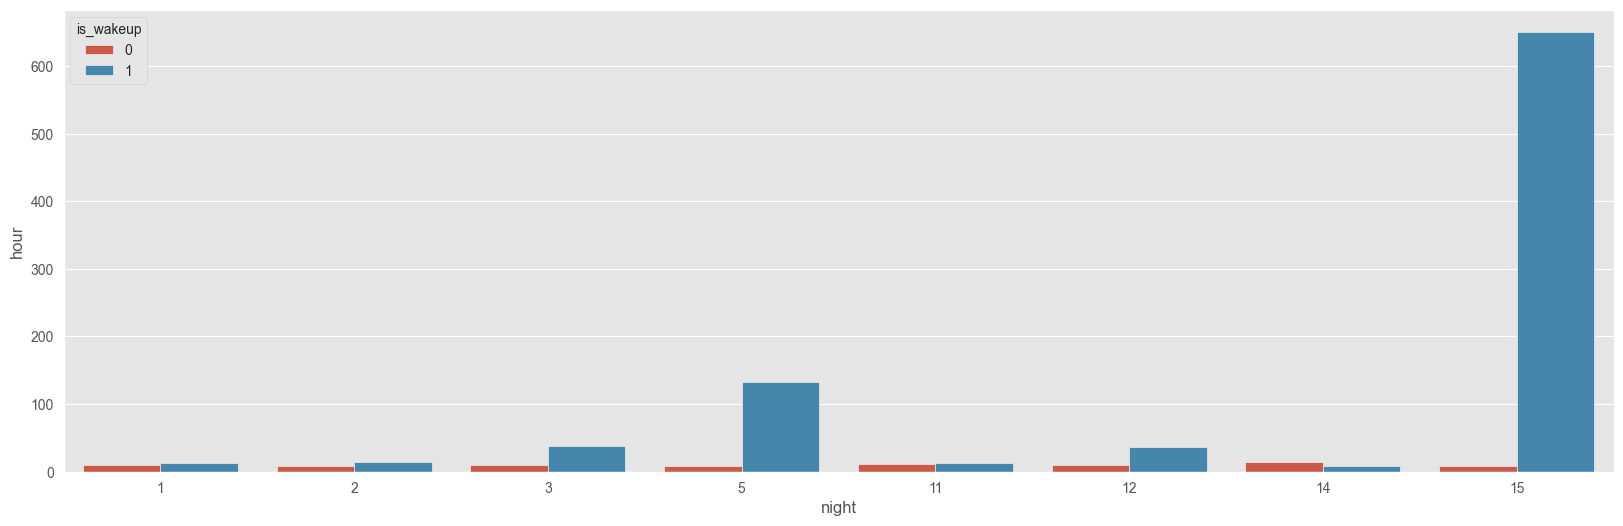

In [24]:
plt.figure(figsize=(20, 6))
sns.barplot(data=pivot.to_pandas(), x='night', y='hour', hue='is_wakeup')

In [13]:
# merge
query = f"""
select p.*
, c.is_wakeup
, strftime(p.timestamp, '%Y-%m-%d') as grass_date
, strftime(p.timestamp, '%H:%M:%S') as grass_hour
from df_parquet p
left join df_csv c on p.series_id = c.series_id and p.timestamp = c.timestamp
order by p.series_id, p.timestamp
"""
df_merge_full = (
    duckdb.sql(query).pl()
    .with_columns(pl.col('is_wakeup').forward_fill())
    .shrink_to_fit()
)

# filter labels have 1 labels
tmp = df_merge_full.groupby('series_id').agg(pl.col('is_wakeup').n_unique())
exclude_lst = tmp.filter(pl.col('is_wakeup') < 2)['series_id'].unique().to_list()
print(len(exclude_lst))

df_merge_full = df_merge_full.filter(~pl.col('series_id').is_in(exclude_lst))

print(df_merge_full.shape, df_merge_full['series_id'].n_unique())
df_merge_full.head(10)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

8
(124822080, 8) 269


series_id,step,anglez,enmo,timestamp,is_wakeup,grass_date,grass_hour
str,i32,f32,f32,datetime[μs],i32,str,str
"""038441c925bb""",0,2.6367,0.0217,2018-08-14 19:30:00,null,"""2018-08-14""","""19:30:00"""
"""038441c925bb""",1,2.6368,0.0215,2018-08-14 19:30:05,null,"""2018-08-14""","""19:30:05"""
"""038441c925bb""",2,2.637,0.0216,2018-08-14 19:30:10,null,"""2018-08-14""","""19:30:10"""
"""038441c925bb""",3,2.6368,0.0213,2018-08-14 19:30:15,null,"""2018-08-14""","""19:30:15"""
"""038441c925bb""",4,2.6368,0.0215,2018-08-14 19:30:20,null,"""2018-08-14""","""19:30:20"""
"""038441c925bb""",5,2.6367,0.0217,2018-08-14 19:30:25,null,"""2018-08-14""","""19:30:25"""
"""038441c925bb""",6,2.6367,0.0217,2018-08-14 19:30:30,null,"""2018-08-14""","""19:30:30"""
"""038441c925bb""",7,2.6367,0.0218,2018-08-14 19:30:35,null,"""2018-08-14""","""19:30:35"""
"""038441c925bb""",8,2.798,0.0223,2018-08-14 19:30:40,null,"""2018-08-14""","""19:30:40"""


In [14]:
label_stats = df_merge_full['is_wakeup'].value_counts() 
label_stats.with_columns((pl.col('counts') / pl.col('counts').sum()).alias('pct'))

is_wakeup,counts,pct
i32,u32,f64
0,29853816,0.239171
1,94963272,0.760789
null,4992,0.00004


## 2.2 check features

In [15]:
def plot(x, series_id, data, onset_time, wakeup_time, save=False):
    fig, axes = plt.subplots(2, 1, figsize=(20, 10))
    axes = axes.flatten()
    for i, v in enumerate(['anglez', 'enmo']):
        sns.lineplot(data=data, x=x, y=v, hue='is_wakeup', ax=axes[i])
        for onset in onset_time:
            axes[i].axvline(x=onset, color='r', linestyle='--', label='onset')
        for wakeup in wakeup_time:
            axes[i].axvline(x=wakeup, color='g', linestyle='--', label='wakeup')
        
    # label
    handles, labels = fig.gca().get_legend_handles_labels()
    new_labels, new_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in new_labels:
            new_handles.append(handle)
            new_labels.append(label)
    for i, v in enumerate(['anglez', 'enmo']):
        axes[i].legend(list(set(new_handles)), list(set(new_labels)), loc='upper right')
        
    fig.suptitle(f'series id {series_id}', fontsize=16)
    fig.tight_layout()
    if save:
        fig.savefig(path / f'media/{series_id}.png', dpi=300)
        plt.close('all')   
        plt.close(fig)
        gc.collect()
    

def eda_series(series_id, df_merge_full, df_csv, save=False):
    filter_ = pl.col('series_id') == series_id
    unit_merge = df_merge_full.filter(filter_)
    unit_label = df_csv.filter(filter_)
    
    onset_time = unit_label.filter(pl.col('event') == 'onset')['timestamp']
    wakeup_time = unit_label.filter(pl.col('event') == 'wakeup')['timestamp']

    plot('timestamp', series_id, unit_merge, onset_time, wakeup_time,save)

In [16]:
# series_id = '03d92c9f6f8a'
# eda_series(series_id, df_merge_full, df_csv)

In [17]:
# series_id = '038441c925bb'
# eda_series(series_id, df_merge_full, df_csv)

In [18]:
df_merge_full.write_parquet(path / 'clean.parquet', use_pyarrow=True)

In [19]:
run = df_merge_full['series_id'].unique().to_list()
f = partial(eda_series,  df_merge_full=df_merge_full, df_csv=df_csv, save=True)
with tqdm(total=len(run)) as pbar:
    with ThreadPoolExecutor(max_workers=6) as executor:
        futures = {executor.submit(f, arg): arg for arg in run}
        results = {}
        for future in as_completed(futures):
            arg = futures[future]
            results[arg] = future.result()
            pbar.update(1)

100%|██████████| 269/269 [19:05<00:00,  4.26s/it]
